In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.options.mode.chained_assignment = None

Before we deep-dive into H5 there is one think i want to mention:
i actually made a mistake in the 4th homework (should've specified the window of size 1). I misinterpreted the meaning of "window size" in this case. After fixing it to be equal 1 MSE actually improves and becomes better than for other 2 methods (0.9x versus 1.5x which was before).

In [38]:
# download the souvenir sales file:
# link: https://www.dropbox.com/scl/fi/2i6hfk4wfc4itldtghuze/souvenir_sales.csv?rlkey=a22ml7tk2d4w6yowxwwfbxusq&st=g70jpm9u&dl=0
!wget -O souvenir_sales.csv https://www.dropbox.com/scl/fi/2i6hfk4wfc4itldtghuze/souvenir_sales.csv?rlkey=a22ml7tk2d4w6yowxwwfbxusq&st=g70jpm9u&dl=0

--2024-05-14 12:21:33--  https://www.dropbox.com/scl/fi/2i6hfk4wfc4itldtghuze/souvenir_sales.csv?rlkey=a22ml7tk2d4w6yowxwwfbxusq
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf9b9bea10ba70b711eea5df9fa.dl.dropboxusercontent.com/cd/0/inline/CS5k3P72R-Glhe2a5Jl9RlATCU_FKLMsmO6rXg7FeEPi0_2oKGS5lXo9sCcGS6AvYOWzxoK8EgG9mVW0ScMr0TnnUQqw2biJA3DyqUpH1dy98Oi5uKyYMzD5k-Sdao0MIqVWs7pcHOoPUQP6sjbwANmZ/file# [following]
--2024-05-14 12:21:34--  https://ucf9b9bea10ba70b711eea5df9fa.dl.dropboxusercontent.com/cd/0/inline/CS5k3P72R-Glhe2a5Jl9RlATCU_FKLMsmO6rXg7FeEPi0_2oKGS5lXo9sCcGS6AvYOWzxoK8EgG9mVW0ScMr0TnnUQqw2biJA3DyqUpH1dy98Oi5uKyYMzD5k-Sdao0MIqVWs7pcHOoPUQP6sjbwANmZ/file
Resolving ucf9b9bea10ba70b711eea5df9fa.dl.dropboxusercontent.com (ucf9b9bea10ba70b711eea5df9fa.dl.dropboxusercontent.com)... 162.125.5.15

In [39]:
df = pd.read_csv('souvenir_sales.csv',decimal=',')
display(df)

,Date,Sales
0,Jan.95,1664.81
1,Feb.95,2397.53
2,Mar.95,2840.71
3,Apr.95,3547.29
4,May.95,3752.96
...,...,...
79,Aug.01,28586.52
80,Sep.01,30505.41
81,Oct.01,30821.33
82,Nov.01,46634.38


([<matplotlib.axis.XTick at 0x7fbedd1b13f0>,
 [Text(0, 0, '1995'),
  Text(12, 0, '1996'),
  Text(24, 0, '1997'),
  Text(36, 0, '1998'),
  Text(48, 0, '1999'),
  Text(60, 0, '2000'),
  Text(72, 0, '2001'),
  Text(84, 0, '2002')])

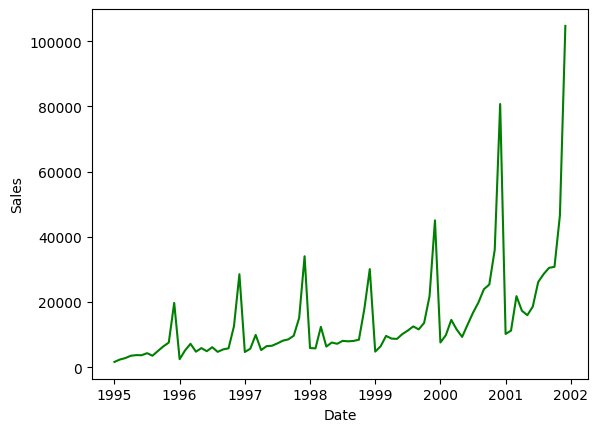

In [40]:
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Sales'], 'g-')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.xticks(np.arange(0, 85, 12), np.arange(1995, 2003, 1))

# actually, from plot we can see, that it has overall growing trend
# with stable seasonality (intense growth right at the end of the year)

ADF-statistic: 2.316544104902997
p-value: 0.9989654538596132
------------------
ADF-statistic: -2.1654800923661037
p-value: 0.21901181581867263
------------------
ADF-statistic: -8.661375066146507
p-value: 4.812257360867916e-14
------------------


([<matplotlib.axis.XTick at 0x7fbedd1bbf10>,
 [Text(0, 0, '1995'),
  Text(12, 0, '1996'),
  Text(24, 0, '1997'),
  Text(36, 0, '1998'),
  Text(48, 0, '1999'),
  Text(60, 0, '2000'),
  Text(72, 0, '2001')])

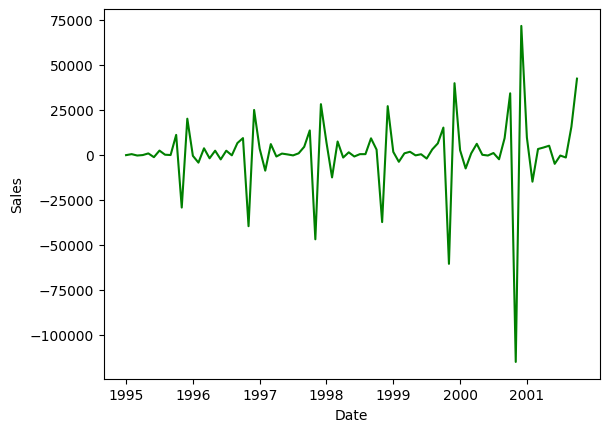

In [41]:
# Let's check for stationarity by running the ADF-test:
ADF_result = adfuller(df['Sales'])
print(f'ADF-statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
print('------------------')
# since we have a positive number representing our adf-statistic,
# as well as a 'very-close-to-one' p-value we have to apply (at least)
# first-order differencing in order to achieve stationarity of our process.

# applying the 1st order differencing:
sales_diff = np.diff(df['Sales'], n=1)
ADF_result = adfuller(sales_diff)
print(f'ADF-statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
print('------------------')
# even though the adf-statistic is now a negative number
# the p-value (which is as far as i know represents the randomness of achieving
# this exact adf-statistic value), so we need to apply another differencing:
sales_diff2 = np.diff(sales_diff, n=1)
ADF_result = adfuller(sales_diff2)
print(f'ADF-statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
print('------------------')
# now the p-value is close to 0 and adf-statistic is reasonably large negative
# number.

# let's also see, how does the time series look like now:
fig, ax = plt.subplots()
ax.plot(df['Date'].values[:-2], sales_diff2, 'g-')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.xticks(np.arange(0, 83, 12), np.arange(1995, 2002, 1))

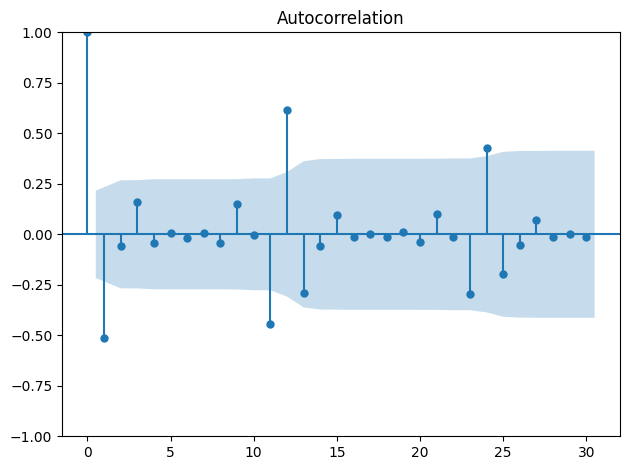

In [42]:
# let's plot acf-plot:
plot_acf(sales_diff2, lags=30)
plt.tight_layout()
# we can see a sinusoidal-like pattern here,
# which means that we are potentially dealing with AR-process,
# since each value has its own coefficient and has different
# influence on future values, so some of them will be neglected in some way.

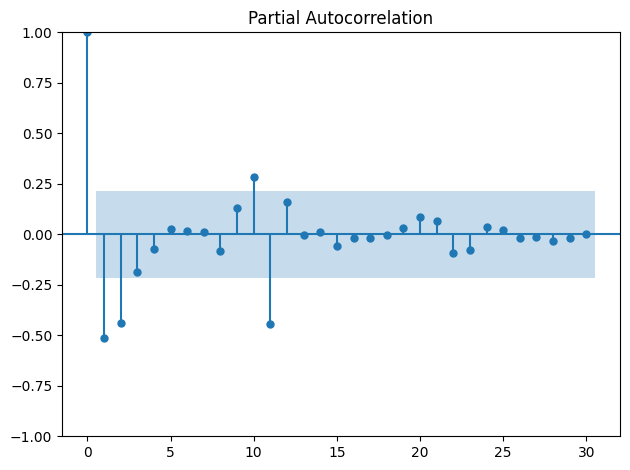

In [43]:
# In order to determine what is the order of AR-process,
# we need to plot partial ACF-plot:
plot_pacf(sales_diff2, lags=30)
plt.tight_layout()
# we have AR process of at least 2nd order. The 3rd is almost significant.
# all the others are rather random than have any sense, since we real data and
# not generated one, so some fluctuations in this case are possible.
# they may also reflect seasonal growth at the end of the year.
# So we have AR-process of order 2.

In [44]:
# train-test split:
train = sales_diff2[:-12]
test = sales_diff2[-12:]
print(train.shape, test.shape)
print(df['Sales'].shape)
# if we compare the dimmensionality of our train-test split and the source one
# we can spot that they have a difference of 2, that's because we applied
# 2nd order differencing (the first one was to the original time series,
# while the second one for the already differenced one,
# since it wasn't stationary).

(70,) (12,)
(84,)


In [45]:
# first we will use baseline methods (historical mean, last known value) and
# then apply the SARIMAX function:

# historical mean:
historical_mean = np.mean(train)
pred_mean = np.full(len(test), historical_mean)
historical_mean_error = mean_squared_error(test, pred_mean)

# last known value:
pred_last_known = test
pred_last_known = np.roll(pred_last_known, 1)
pred_last_known[0] = train[-1]
next_value_error = mean_squared_error(test, pred_last_known)

# SARIMAX function:
df_ar = pd.DataFrame(sales_diff2, columns=['value'])
train_ar = df[:-12]
test_ar = df[-12:]
window_size = 2
pred_AR = []
for i in range(len(train_ar), len(train_ar) + len(test_ar), window_size):
  model = SARIMAX(df_ar[:i], order=(2,0,0))
  res = model.fit(disp=False)
  predictions = res.get_prediction(0, i + window_size - 1)
  oos_pred = predictions.predicted_mean.iloc[-window_size:]
  pred_AR.extend(oos_pred)
ar_error = mean_squared_error(test, pred_AR)

([<matplotlib.axis.XTick at 0x7fbedcf283d0>,
 [Text(0, 0, '1995'),
  Text(12, 0, '1996'),
  Text(24, 0, '1997'),
  Text(36, 0, '1998'),
  Text(48, 0, '1999'),
  Text(60, 0, '2000'),
  Text(72, 0, '2001')])

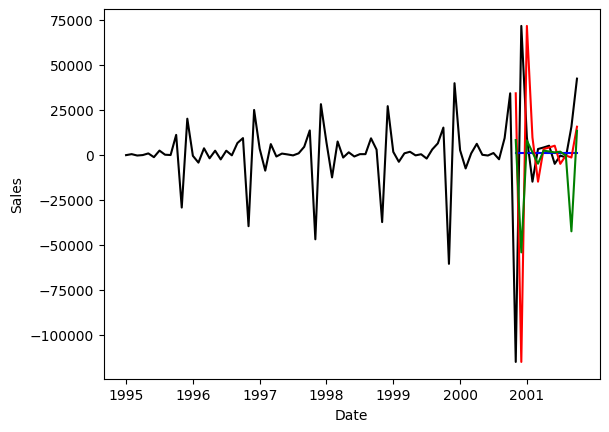

In [46]:
fig, ax = plt.subplots()
ax.plot(df['Date'].values[:-2], sales_diff2, 'k')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.plot(df['Date'].values[-14:-2], pred_mean, 'b-')
ax.plot(df['Date'].values[-14:-2], pred_last_known, 'r-')
ax.plot(df['Date'].values[-14:-2], pred_AR, 'g-')
plt.xticks(np.arange(0, 83, 12), np.arange(1995, 2002, 1))

In [47]:
# MSE:
print(historical_mean_error)
print(next_value_error)
print(ar_error)

1731984003.7905128
5252062259.5052595
2969885253.5442615


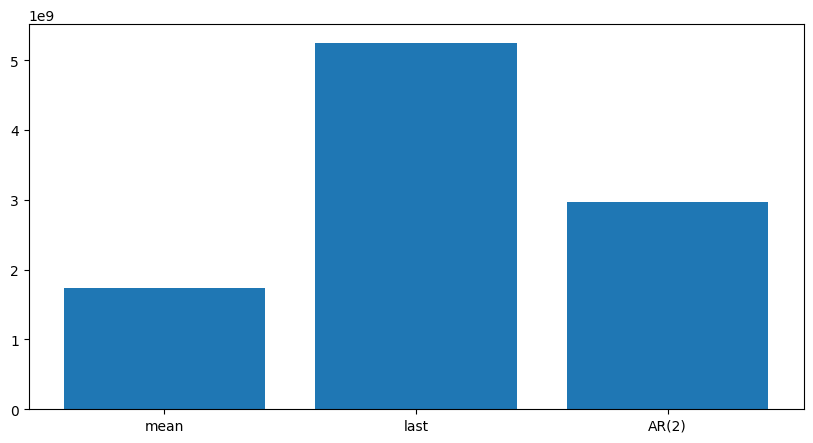

In [48]:
# bar plots for MSE:
data = {'mean':historical_mean_error, 'last':next_value_error, 'AR(2)':ar_error}
metrics = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(metrics, values)
plt.show()

In [49]:
# now let's do a reverse differencing in order to compare predictions
# with actual values:
# since the best method is mean we will examine it:
pred_mean_rediff = np.zeros(12)
pred_mean_rediff = df['Sales'].iloc[-12] + pred_mean.cumsum().cumsum()
# since we had made 2-nd order differencing we have to apply cumsum() twice

([<matplotlib.axis.XTick at 0x7fbedce1b100>,
 [Text(0, 0, '2001'), Text(12, 0, '2002')])

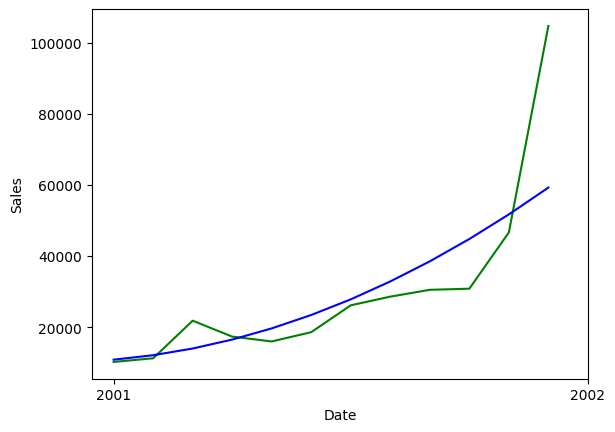

In [50]:
fig, ax = plt.subplots()
ax.plot(df['Date'].values[-12:], df['Sales'].values[-12:], 'g-')
ax.plot(df['Date'].values[-12:], pred_mean_rediff, 'b-')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.xticks(np.arange(0, 13, 12), np.arange(2001, 2003, 1))

In [51]:
# calculating the MAE:
print(mean_absolute_error(test, pred_mean_rediff))
# it means that for each prediciton we have a mean error of 38k either
# in positive or negative direction.

38079.386571428586
